##Loading Pre-Trained BERT

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 11.9 MB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
     |████████████████████████████████| 6.5 MB 32.7 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 67 kB 3.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


##Imports - Downloads

In [2]:
# for reading csv into dataframes
import pandas as pd

# for progress bar
from tqdm import tqdm_notebook as tqdm

# for neural networks, tensors, dataloader (pytorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# for score metrics (precision, recall and f1)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# for data cleaning/preprocessing
import re
import string
import nltk

# download stop words from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# for the learning curves
import matplotlib.pyplot as plt
% matplotlib inline

# for the roc curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# for seeding - so that we get same results every time we run the notebook
import random
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(seed)

import warnings
warnings.filterwarnings('ignore')

# for the bert model and tokenizer
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import logging
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
cuda


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Useful Functions

In [3]:
def data_cleaning(text):
  """ function that performs necessary and useful text cleaning """
  # lower case text
  text = text.lower()
  # remove unicode characters unreadable in ascii
  text = text.encode('ascii', 'ignore').decode()
  # Remove mentions
  text = re.sub("@\S+", " ", text)
  # Remove URL
  text = re.sub("https*\S+", " ", text)
  # Remove hashtags
  #text = re.sub("#\S+", " ", text)
  # Remove the large spaces/tabs
  text = re.sub('\s{2,}', " ", text)
  # Remove the ' character
  text = re.sub("\'\w+", '', text)
  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  # Remove numbers
  text = re.sub(r'\w*\d+\w*', '', text)
  # Remove stop words
  text = ' '.join([word for word in text.split(' ') if word not in stop_words])
  return text

def print_scores(y_true, y_pred, train_set):
  """ function that prints classification scores """
  if train_set:
    print("Classification scores for training set:\n")
  else:
    print("Classification scores for validation/test set:\n")
  
  # print weighted average scores
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  score = f1_score(y_true, y_pred, average='weighted')
  print("Weighted average Precision = ", precision)
  print("Weighted average Recall    = ", recall)
  print("Weighted average F1 score  = ", score)
  print("\n")

  # print scores for each class
  precision = precision_score(y_true, y_pred, average=None)
  recall = recall_score(y_true, y_pred, average=None)
  score = f1_score(y_true, y_pred, average=None)

  for i in range(score.shape[0]):
    print("Class ", i, " Precision = ", precision[i])
    print("Class ", i, " Recall    = ", recall[i])
    print("Class ", i, " F1 score  = ", score[i])
    print("\n")

  print("\n")

def make_subplot(epochs, train_scores, val_scores, title_1, train_losses, val_losses, title_2):
  """ make subplot of train epochs in relation to train and validation scores and losses (plot the learning curves) """
  # plot learning curves
  print("\n")
  fig = plt.figure(figsize=(16, 6), dpi=120)
  ax1 = fig.add_subplot(1,2,1)
  plt.plot(epochs, train_scores, label="Training Score")
  plt.plot(epochs, val_scores, label="Validation/Test Score")
  plt.xlabel("Epoch")
  plt.ylabel("Classification F1 Score")
  plt.legend()
  plt.title(title_1)

  ax2 = fig.add_subplot(1,2,2)
  plt.plot(epochs, train_losses, label="Training Loss")
  plt.plot(epochs, val_losses, label="Validation/Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-Entropy Loss")
  plt.legend()
  plt.title(title_2)

  plt.show()

def plot_roc_curve(y_true, y_pred):
  """ plots roc curve """
  # Binarize the y_true, y_pred to form one hot vectors of size (size of validation set, #classes)
  y_test = label_binarize(y_true, classes=[0, 1, 2])
  #y_score = label_binarize(y_pred, classes=[0, 1, 2])
  y_score = y_pred
  n_classes = 3

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve
  fig = plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
  
  for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for all classes')
  plt.legend(loc="lower right")
  plt.show()

def model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses):
  """ prints model's results (classification scores, learning curves, roc curves) """
  # Print f1, precision, recall score for final model on training set
  model.eval()
  y = []
  y_hat = []
  for train_batch in train_dataloader:
    # divide batch to its components
    x_batch = train_batch[0].to(device)          # vectorized sequences
    masks = train_batch[1].to(device)            # attention masks for sequences
    y_batch = train_batch[2].to(device)          # labels
    # no need for gradients to be updated
    with torch.no_grad():
      # perform forward pass on current batch
      out = model(x_batch, token_type_ids=None, attention_mask=masks)
    y_pred = out.logits
    # apply softmax on raw logits to get softmax class scores for current batch
    probs = F.softmax(y_pred, dim=1)
    # apply argmax on softmax scores to get predicted labels for current batch
    y_label_pred = probs.argmax(dim=1)
    y.append(y_batch)
    y_hat.append(y_label_pred)

  true_labels = torch.cat(y, dim=0)
  pred_labels = torch.cat(y_hat, dim=0)
  print_scores(true_labels.detach().cpu().numpy(), pred_labels.detach().cpu().numpy(), True)

  #Print f1, precision, recall score for final model on test/validation set
  y = []
  y_hat = []
  y_probs = []
  for val_batch in val_dataloader:
    # divide batch to its components
    x_batch = val_batch[0].to(device)          # vectorized sequences
    masks = val_batch[1].to(device)            # attention masks for sequences
    y_batch = val_batch[2].to(device)          # labels
    # no need for gradients to be updated
    with torch.no_grad():
      # perform forward pass on current batch
      out = model(x_batch, token_type_ids=None, attention_mask=masks)
    y_pred = out.logits
    # apply softmax on raw logits to get softmax class scores for current batch
    probs = F.softmax(y_pred, dim=1)
    # apply argmax on softmax scores to get predicted labels for current batch
    y_label_pred = probs.argmax(dim=1)
    y.append(y_batch)
    y_hat.append(y_label_pred)
    y_probs.append(probs)

  true_labels = torch.cat(y, dim=0)
  pred_labels = torch.cat(y_hat, dim=0)
  y_probs = torch.cat(y_probs, dim=0)
  print_scores(true_labels.detach().cpu().numpy(), pred_labels.detach().cpu().numpy(), False)

  # Print Learning Curve
  #make_subplot(epochs, train_scores, val_scores, "Classification Score Learning Curve", train_losses, val_losses, "Loss Learning Curve")

  # Print Roc Curve
  plot_roc_curve(true_labels.detach().cpu().numpy(), y_probs.detach().cpu().numpy())

def sentences_to_sequences(sentences, max_length):
  """ function that converts a list of sentences to a tensor of integer sequences, sequences are produced from vectorization of sentences """
  """ returns 1) input_ids tensor (vectorized sentences)  
              2) attention_masks tensor (0 for padded tokens, 1 otherwise)  
              segment ids not needed since we only have one sentence in each example """
  input_ids = np.zeros((len(sentences), max_length)).astype(np.int)
  attention_masks = np.zeros((len(sentences), max_length)).astype(np.int)
  index = 0
  for sentence in sentences:
    # initialize sequence
    sequence = np.zeros(max_length).astype(np.int)             
    # initialize mask
    mask = np.zeros(max_length).astype(np.int)                 
    # add special BERT tokens
    sentence = "[CLS] " + sentence + " [SEP]"                   
    # tokenize each sentence to its words
    tokenized_sentence = tokenizer.tokenize(sentence)          
    # Map the token strings to their vocabulary indices.
    sequence_indices = tokenizer.convert_tokens_to_ids(tokenized_sentence)  
    length = min(max_length, len(sequence_indices))
    # sequence gets padded with [PAD]/zeros or truncated 
    sequence[:length] = np.array(sequence_indices[:length])
    # add [SEP] token if it got truncated    
    if sequence[length-1] != tokenizer.convert_tokens_to_ids('[SEP]'):
      sequence[length-1] = tokenizer.convert_tokens_to_ids('[SEP]')
    # set attention mask to 1 for non padded tokens 
    mask[:length] = np.array([1 for i in range(length)])       
    input_ids[index] = sequence
    attention_masks[index] = mask
    index += 1
  # return input_ids, segment_ids, attention masks as tensors
  return torch.from_numpy(input_ids), torch.from_numpy(attention_masks)

def execute_training(model, loss_func, optimizer, batch_size, num_epochs, clip_grad=True, stop_early=True):
  """ function that trains the model in bathes of batch_size, for num_epochs, using given loss function, optimizer
      returns the train_losses, val_losses, train_scores, val_scores and the final trained model
      clip_grad : Flag that indicates if gradient clipping will be used (default is True)
      stop_early : Flag that indicates if early stopping regularization will be used (default is True) """
   
  #Initialize lists we care about
  train_losses = []
  val_losses = []
  train_scores = []
  val_scores = []

  # for early stopping
  min_val_loss = np.Inf   # keeps track of minimum validation loss thus far
  epochs_no_improve = 0   # keeps track of number of consecutive epochs where validation loss did not improve over minimum validation loss
  epoch_tolerance = 3     # if validation loss does not improve over 3 consecutive epochs, we stop training (early stopping)
  epochs_count = 0  

  # run for number of epochs
  for epoch in range(num_epochs):
    train_batch_losses = []
    train_batch_scores = []
    val_batch_losses = []
    val_batch_scores = []
    
    # training the model for current epoch
    model.train()

    # put a progress loop to track remaining training time
    progress_loop = tqdm(train_dataloader, leave=True)

    for train_batch in progress_loop:
      # divide batch to its components
      x_batch = train_batch[0].to(device)          # vectorized sequences
      masks = train_batch[1].to(device)            # attention masks for sequences
      y_batch = train_batch[2].to(device)          # labels
      #Delete previously stored gradients
      optimizer.zero_grad()
      # perform forward pass on current batch
      out = model(x_batch, token_type_ids=None, attention_mask=masks)
      y_pred = out.logits
      # calculate the loss of current batch
      loss = loss_func(y_pred, y_batch)
      # append the loss value
      train_batch_losses.append(loss.item())
      # apply softmax on raw logits to get softmax class scores for current batch
      probs = F.softmax(y_pred, dim=1)
      # apply argmax on softmax scores to get predicted labels for current batch
      y_label_pred = probs.argmax(dim=1)
      # calculate and append the f1 score value of current batch
      train_batch_scores.append(f1_score(y_batch.detach().cpu().numpy(), y_label_pred.detach().cpu().numpy(), average='weighted'))
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()

      if clip_grad is True:
        # Perform gradient clippint with threshold of 2.0
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
      progress_loop.set_description(f'Epoch {epoch}')
      progress_loop.set_postfix(loss=loss.item())
    
    # append average training loss for epoch
    train_losses.append(sum(train_batch_losses)/len(train_dataloader))
    # append average training score for epoch
    train_scores.append(sum(train_batch_scores)/len(train_dataloader))
    
    # compute and append training loss/score for validation/test set for this epoch
    model.eval()
    # validate model for current epoch
    for val_batch in val_dataloader:
      # divide batch to its components
      x_batch = val_batch[0].to(device)          # vectorized sequences
      masks = val_batch[1].to(device)            # attention masks for sequences
      y_batch = val_batch[2].to(device)          # labels
      # no need for gradients to be updated
      with torch.no_grad():
        # perform forward pass on current batch
        out = model(x_batch, token_type_ids=None, attention_mask=masks)
      y_pred = out.logits
      # append the loss value for current batch
      val_batch_losses.append((loss_func(y_pred, y_batch)).item())
      # apply softmax on raw logits to get softmax class scores for current batch
      probs = F.softmax(y_pred, dim=1)
      # apply argmax on softmax scores to get predicted labels for current batch
      y_label_pred = probs.argmax(dim=1)
      # calculate and append the f1 score value of current batch
      val_batch_scores.append(f1_score(y_batch.detach().cpu().numpy(), y_label_pred.detach().cpu().numpy(), average='weighted'))
    
    # append average validation loss for epoch
    val_losses.append(sum(val_batch_losses)/len(val_dataloader))
    # append average validation score for epoch
    val_scores.append(sum(val_batch_scores)/len(val_dataloader))
    # print epoch results
    string = f'\rEpoch {epoch+1}/{num_epochs} -- Train Loss: {train_losses[-1]:0.4f} -- Validation Loss: {val_losses[-1]:0.4f}'
    print(string)

    epochs_count += 1
    # check for early stopping
    if stop_early is True:
      if val_losses[-1] < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_losses[-1]
      else:
        epochs_no_improve += 1
      
      if (epochs_no_improve == epoch_tolerance):
        print('Early Stopping\n')
        break

  epochs = [epoch+1 for epoch in range(epochs_count)]
  return train_losses, val_losses, train_scores, val_scores, epochs, model

##Read and seperate training/validation sets

In [4]:
# MAIN FUNCTIONALITY

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")
#training_df.head()
#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")   # <------------- REPLACE TEST SET PATH HERE

cleaning = True   # TODO : EXPERIMENT WITH/WITHOUT DATA CLEANING

if cleaning:
  # apply text cleaning for the tweets as pre-processing for the training set
  training_df['tweet'] = training_df['tweet'].apply(data_cleaning)
  # apply text cleaning for the tweets as pre-processing for the validation set
  validation_df['tweet'] = validation_df['tweet'].apply(data_cleaning)

#Seperate tweet and label columns into seperate dataframes for the training set
train_tweet_df = pd.DataFrame(training_df, columns=[training_df.columns[1]])
train_label_df = pd.DataFrame(training_df, columns=[training_df.columns[-1]])
#Seperate tweet and label columns into seperate dataframes for the validation set
val_tweet_df = pd.DataFrame(validation_df, columns=[training_df.columns[1]])
val_label_df = pd.DataFrame(validation_df, columns=[training_df.columns[-1]])

train_sentences = [x for x in train_tweet_df['tweet']]
val_sentences = [x for x in val_tweet_df['tweet']]
num_classes = 3

## Convert tweet sentences to BERT-formatted vectorized sequences

In [5]:
# define a fixed length for the encoding of each sentence (maximum number of words of sentence)
max_length = 60  # if a sentence has more than 60 words, it gets padded, otherwise it gets truncated 
#Save in tensors
# for training set
x_train = sentences_to_sequences(train_sentences, max_length)
y_train = torch.tensor(train_label_df.values, dtype=torch.long)
y_train = y_train.view(-1)
# for validation set
x_val = sentences_to_sequences(val_sentences, max_length)
y_val = torch.tensor(val_label_df.values, dtype=torch.long)
y_val = y_val.view(-1)

## Model / Hyperparameters

In [6]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3,  output_attentions = False, output_hidden_states = False)
model.to(device)

# more hyperparamenter tuning
batch_size = 32
num_epochs = 2
learning_rate = 3e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Create training / validation datasets using DataLoader

In [7]:
#Initialize dataloader for training set
train_dataset = torch.utils.data.TensorDataset(x_train[0], x_train[1], y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Initialize dataloader for validation set
val_dataset = torch.utils.data.TensorDataset(x_val[0], x_val[1], y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

##Training

In [8]:
# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/2 -- Train Loss: 0.7219 -- Validation Loss: 0.6510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/2 -- Train Loss: 0.5632 -- Validation Loss: 0.6153


##Results

Classification scores for training set:

Weighted average Precision =  0.8756468595947157
Weighted average Recall    =  0.8754381572358538
Weighted average F1 score  =  0.8754844329987088


Class  0  Precision =  0.9095983662355344
Class  0  Recall    =  0.8958165728077232
Class  0  F1 score  =  0.902654867256637


Class  1  Precision =  0.7719553614750121
Class  1  Recall    =  0.7674867342016402
Class  1  F1 score  =  0.7697145621673923


Class  2  Precision =  0.8697108066971081
Class  2  Recall    =  0.8865787432117921
Class  2  F1 score  =  0.8780637725701115




Classification scores for validation/test set:

Weighted average Precision =  0.7478249071971683
Weighted average Recall    =  0.7471516213847502
Weighted average F1 score  =  0.7474748368113778


Class  0  Precision =  0.8125
Class  0  Recall    =  0.8056338028169014
Class  0  F1 score  =  0.8090523338048091


Class  1  Precision =  0.5714285714285714
Class  1  Recall    =  0.581081081081081
Class  1  F1 score  =  0.5762

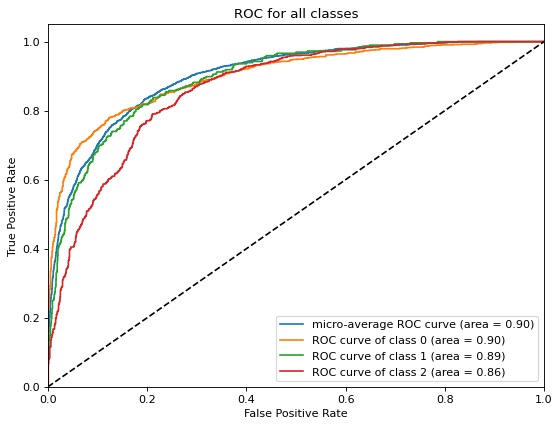

In [9]:
# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)